In [1]:
import pandas as pd
import numpy as np

#model selection
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_validate
from scipy.stats import uniform

#############
#preprocessing

#missing features


#scaling
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#oversampling
from imblearn.pipeline import Pipeline #can't use standard Pipeline with SMOTE
from imblearn.over_sampling import SMOTE


####################
#models 
from sklearn.tree import DecisionTreeClassifier

from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier





#model_evaluation
from sklearn.metrics import make_scorer, recall_score, precision_score,matthews_corrcoef


sensitivity = make_scorer(recall_score, pos_label=1)
specificity = make_scorer(recall_score, pos_label=0)
PPV = make_scorer(precision_score, pos_label=1)
NPV = make_scorer(precision_score, pos_label=0)
MCC = make_scorer(matthews_corrcoef)
score_metrics = {'roc_auc':'roc_auc','accuracy':'accuracy','MCC':MCC,
                 'bal_acc':'balanced_accuracy', 'sensitivity' : sensitivity,
                 'specificity': specificity,'PPV': PPV, 'NPV' : NPV, 'f1':'f1'}


In [2]:
df = pd.read_csv("brca_merged_data.csv",index_col= 0)
print(df.shape)
df.head()

(876, 364)


,#Patient Identifier,Sample Identifier,Oncotree Code,Cancer Type,Cancer Type Detailed,Tumor Type,Neoplasm Histologic Grade,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site,...,22_mutcount,3_mutcount,4_mutcount,5_mutcount,6_mutcount,7_mutcount,8_mutcount,9_mutcount,X_mutcount,Y_mutcount
0,TCGA-3C-AALI,TCGA-3C-AALI-01,IDC,Invasive Breast Carcinoma,Breast Invasive Ductal Carcinoma,Infiltrating Ductal Carcinoma,NaN,No,Yes,3C,...,9.0,54.0,29.0,32.0,38.0,41.0,32.0,22.0,29.0,NaN
1,TCGA-3C-AALK,TCGA-3C-AALK-01,IDC,Invasive Breast Carcinoma,Breast Invasive Ductal Carcinoma,Infiltrating Ductal Carcinoma,NaN,No,Yes,3C,...,3.0,5.0,2.0,9.0,5.0,2.0,NaN,4.0,4.0,NaN
2,TCGA-4H-AAAK,TCGA-4H-AAAK-01,ILC,Invasive Breast Carcinoma,Breast Invasive Lobular Carcinoma,Infiltrating Lobular Carcinoma,NaN,Yes,No,4H,...,NaN,1.0,3.0,2.0,NaN,2.0,2.0,4.0,3.0,NaN
3,TCGA-5T-A9QA,TCGA-5T-A9QA-01,BRCNOS,Invasive Breast Carcinoma,Breast Invasive Carcinoma (NOS),Other,NaN,Yes,No,5T,...,4.0,8.0,8.0,NaN,3.0,4.0,2.0,2.0,10.0,NaN
4,TCGA-A1-A0SF,TCGA-A1-A0SF-01,IDC,Invasive Breast Carcinoma,Breast Invasive Ductal Carcinoma,Infiltrating Ductal Carcinoma,NaN,No,Yes,A1,...,1.0,3.0,6.0,3.0,6.0,6.0,1.0,2.0,1.0,NaN


In [3]:
df.isna().sum()[210:260]

CTNNA1|alpha-Catenin                          876
NKX2-1|TTF1                                   876
CASP3|Caspase-3                               798
CASP9|Caspase-9                               798
PARP1|PARP1                                   798
COPS5|JAB1                                    798
PATIENT_ID                                      0
SUBTYPE                                        79
CANCER_TYPE_ACRONYM                             0
OTHER_PATIENT_ID                                0
AGE                                             0
SEX                                             0
AJCC_PATHOLOGIC_TUMOR_STAGE                     4
AJCC_STAGING_EDITION                          117
DAYS_LAST_FOLLOWUP                             85
DAYS_TO_BIRTH                                  14
DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS            0
ETHNICITY                                     125
FORM_COMPLETION_DATE                            0
HISTORY_NEOADJUVANT_TRTYN                       0


In [4]:
cols = df.columns

print(cols)

Index(['#Patient Identifier', 'Sample Identifier', 'Oncotree Code',
       'Cancer Type', 'Cancer Type Detailed', 'Tumor Type',
       'Neoplasm Histologic Grade', 'Tissue Prospective Collection Indicator',
       'Tissue Retrospective Collection Indicator', 'Tissue Source Site',
       ...
       '22_mutcount', '3_mutcount', '4_mutcount', '5_mutcount', '6_mutcount',
       '7_mutcount', '8_mutcount', '9_mutcount', 'X_mutcount', 'Y_mutcount'],
      dtype='object', length=364)


In [5]:
df['Tumor Type'].value_counts()

Infiltrating Ductal Carcinoma     635
Infiltrating Lobular Carcinoma    153
Other                              38
Mixed Histology (NOS)              23
Mucinous Carcinoma                 14
Metaplastic Carcinoma               6
Medullary Carcinoma                 6
Infiltrating Carcinoma (NOS)        1
Name: Tumor Type, dtype: int64

<AxesSubplot:>

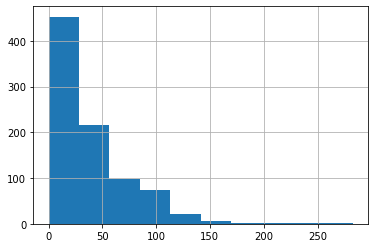

In [6]:
df['OS_MONTHS'].hist()

In [7]:
df['PFS_MONTHS']#.hist(by="OS_STATUS")

0      131.669790
1       47.604958
2       11.440971
3        9.961535
4       48.098103
          ...    
871     11.408094
872     52.963803
873     15.353256
874      5.950620
875    107.045402
Name: PFS_MONTHS, Length: 876, dtype: float64

<AxesSubplot:>

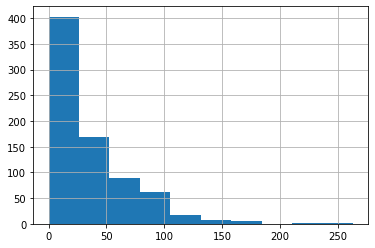

In [8]:
df['DFS_MONTHS'].hist()

# Make list of subset of columns that will need to be modeled

In [9]:
model_cols = list(df.columns[18:209])
model_cols.extend(["AGE","SEX","RACE","TMB (nonsynonymous)",
                   'RADIATION_THERAPY',"Tumor Type"])
model_cols.extend(list(df.columns[248:321]))

<AxesSubplot:>

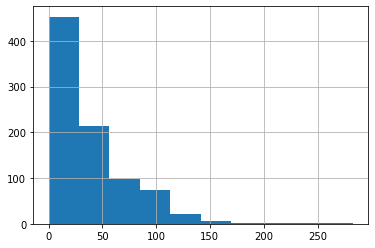

In [10]:
df["DSS_MONTHS"].hist()

In [11]:
df.iloc[:,180:209].isna().sum()

PRDX1|PRDX1                      0
RAB11A RAB11B|Rab11              0
RAB25|Rab25                      0
RPTOR|Raptor                     0
RBM15|RBM15                      0
RICTOR|Rictor                    0
RICTOR|Rictor_pT1135             0
SCD1|SCD1                        0
SRSF1|SF2                        0
WWTR1|TAZ                        0
TIGAR|TIGAR                      0
TGM2|Transglutaminase            0
TFRC|TFRC                        0
TSC1|TSC1                        0
TSC2|Tuberin_pT1462              0
VHL|VHL                          0
XBP1|XBP1                        0
TUBA1B|Acetyl-a-Tubulin-Lys40    0
SQSTM1|p62-LCK-ligand            0
YWHAB|14-3-3_beta                0
YWHAZ|14-3-3_zeta                0
ACVRL1|ACVRL1                    0
DIRAS3|DIRAS3                    0
ANXA1|Annexin-1                  0
PREX1|PREX1                      0
ERCC1|ERCC1                      0
MSH2|MSH2                        0
MSH6|MSH6                        0
DIABLO|Smac         

# Variable Selection

- Patient characteristics
- mutation data
- rppa data
- others?



# Target Variable

- "DSS_STATUS"
- others?


In [12]:
df["DSS_STATUS"].value_counts()
df["DSS_STATUS"].isna().sum()
#notes we are assuming the person dies of cancer
# this might be our only option

19

# Variable Selection

- WEIGHT is missing for all 
- "ETHNICITY" is missing for many "ETHNICITY"

In [13]:
df_model = df.loc[:,model_cols]

In [14]:
print(df["PFS_STATUS"].isna().sum())
df_model['PFS_STATUS'].value_counts()

1


0:CENSORED       761
1:PROGRESSION    114
Name: PFS_STATUS, dtype: int64

In [15]:
print(df["DFS_STATUS"].isna().sum())
df_model['DFS_STATUS'].value_counts()

121


0:DiseaseFree            691
1:Recurred/Progressed     64
Name: DFS_STATUS, dtype: int64

In [16]:
print(df["DSS_STATUS"].isna().sum())
df_model['DSS_STATUS'].value_counts()

19


0:ALIVE OR DEAD TUMOR FREE    791
1:DEAD WITH TUMOR              66
Name: DSS_STATUS, dtype: int64

In [17]:
#remove nonoutcome variables
##'DFS_STATUS', 'DFS_MONTHS', 'PFS_STATUS', 'PFS_MONTHS'

#if using DSS_STATUS
df_model.drop(['DFS_MONTHS','DFS_STATUS', 'PFS_STATUS', 'PFS_MONTHS', "DSS_MONTHS"],axis=1,inplace=True)


#if using PFS_STATUS
#df_model.drop(['DFS_MONTHS','DFS_STATUS', 'DSS_STATUS', 'PFS_MONTHS', "DSS_MONTHS" ],axis=1,inplace=True)


In [18]:
df_model.shape

(876, 265)

In [19]:
sum(df_model.isna().sum() > 100)

68

In [20]:
# dropping columns with greater than 100 missing values

df_model.dropna(axis= 1,thresh=100,inplace=True)

In [21]:
df_model.shape

(876, 203)

# Drop rows with missing outcome variable

In [22]:
#if using DSS_STATUS

df_model.dropna(axis = 0, subset= ["DSS_STATUS"],inplace=True)

#if using PFS_STATUS

#df_model.dropna(axis = 0, subset= ["PFS_STATUS"],inplace=True)


In [23]:
df_model.shape

(857, 203)

In [24]:
pt_cols = ["AGE","SEX", "RACE","TMB (nonsynonymous)", "RADIATION_THERAPY","Tumor Type", "DSS_STATUS"]

In [25]:
df_pt = df_model[pt_cols]

# Define X and Y values

In [26]:
# if using DFS_STATUS

map_dict = {"0:ALIVE OR DEAD TUMOR FREE" : int(0),
            "1:DEAD WITH TUMOR" : int(1)
           }




In [27]:
## using PFS_STATUS

# map_dict = {"0:CENSORED" : int(0),
#             "1:PROGRESSION" : int(1)
#            }


In [28]:
#DSS
X = df_model.drop(labels= ["DSS_STATUS"], axis=1)
y = df_model["DSS_STATUS"].map(map_dict)

#DSS with patient data only
# X = df_pt.drop(labels= ["DSS_STATUS"], axis=1)
# y = df_pt["DSS_STATUS"].map(map_dict)

#PFS
# X = df_model.drop(labels= ["PFS_STATUS"], axis=1)
# y = df_model["PFS_STATUS"].map(map_dict)


In [29]:
for col in list(X.columns):
    print(col)

YWHAE|14-3-3_epsilon
EIF4EBP1|4E-BP1
EIF4EBP1|4E-BP1_pS65
EIF4EBP1|4E-BP1_pT37T46
TP53BP1|53BP1
ACACA ACACB|ACC_pS79
ACACA|ACC1
AKT1 AKT2 AKT3|Akt
AKT1 AKT2 AKT3|Akt_pS473
AKT1 AKT2 AKT3|Akt_pT308
PRKAA1|AMPK_alpha
PRKAA1|AMPK_pT172
AR|AR
ASNS|ASNS
ATM|ATM
BAK1|Bak
BAX|Bax
BCL2|Bcl-2
BCL2L1|Bcl-xL
BECN1|Beclin
CTNNB1|beta-Catenin
BID|Bid
BCL2L11|Bim
JUN|c-Jun_pS73
KIT|c-Kit
MET|c-Met_pY1235
MYC|c-Myc
RAF1|C-Raf
RAF1|C-Raf_pS338
CASP7|Caspase-7_cleavedD198
CAV1|Caveolin-1
PECAM1|CD31
ITGA2|CD49b
CDK1|CDK1
CHEK1|Chk1
CHEK1|Chk1_pS345
CHEK2|Chk2
CHEK2|Chk2_pT68
BIRC2 |cIAP
CLDN7|Claudin-7
COL6A1|Collagen_VI
CCNB1|Cyclin_B1
CCND1|Cyclin_D1
CCNE1|Cyclin_E1
PARK7|DJ-1
DVL3|Dvl3
CDH1|E-Cadherin
EEF2|eEF2
EEF2K|eEF2K
EGFR|EGFR
EGFR|EGFR_pY1068
EGFR|EGFR_pY1173
EIF4E|eIF4E
ESR1|ER-alpha
ESR1|ER-alpha_pS118
MAPK1|ERK2
FN1|Fibronectin
FOXO3|FOXO3a
GAB2|GAB2
GATA3|GATA3
GSK3A GSK3B|GSK3-alpha-beta
GSK3A GSK3B|GSK3-alpha-beta_pS21_S9
ERBB2|HER2
ERBB2|HER2_pY1248
ERBB3|HER3
ERBB3|HER3_pY1298
HSPA1A|

In [30]:
y.value_counts()

0    791
1     66
Name: DSS_STATUS, dtype: int64

In [31]:
#get dummy variables

X = pd.get_dummies(X)

In [32]:
for col in list(X.columns):
    print(col)

YWHAE|14-3-3_epsilon
EIF4EBP1|4E-BP1
EIF4EBP1|4E-BP1_pS65
EIF4EBP1|4E-BP1_pT37T46
TP53BP1|53BP1
ACACA ACACB|ACC_pS79
ACACA|ACC1
AKT1 AKT2 AKT3|Akt
AKT1 AKT2 AKT3|Akt_pS473
AKT1 AKT2 AKT3|Akt_pT308
PRKAA1|AMPK_alpha
PRKAA1|AMPK_pT172
AR|AR
ASNS|ASNS
ATM|ATM
BAK1|Bak
BAX|Bax
BCL2|Bcl-2
BCL2L1|Bcl-xL
BECN1|Beclin
CTNNB1|beta-Catenin
BID|Bid
BCL2L11|Bim
JUN|c-Jun_pS73
KIT|c-Kit
MET|c-Met_pY1235
MYC|c-Myc
RAF1|C-Raf
RAF1|C-Raf_pS338
CASP7|Caspase-7_cleavedD198
CAV1|Caveolin-1
PECAM1|CD31
ITGA2|CD49b
CDK1|CDK1
CHEK1|Chk1
CHEK1|Chk1_pS345
CHEK2|Chk2
CHEK2|Chk2_pT68
BIRC2 |cIAP
CLDN7|Claudin-7
COL6A1|Collagen_VI
CCNB1|Cyclin_B1
CCND1|Cyclin_D1
CCNE1|Cyclin_E1
PARK7|DJ-1
DVL3|Dvl3
CDH1|E-Cadherin
EEF2|eEF2
EEF2K|eEF2K
EGFR|EGFR
EGFR|EGFR_pY1068
EGFR|EGFR_pY1173
EIF4E|eIF4E
ESR1|ER-alpha
ESR1|ER-alpha_pS118
MAPK1|ERK2
FN1|Fibronectin
FOXO3|FOXO3a
GAB2|GAB2
GATA3|GATA3
GSK3A GSK3B|GSK3-alpha-beta
GSK3A GSK3B|GSK3-alpha-beta_pS21_S9
ERBB2|HER2
ERBB2|HER2_pY1248
ERBB3|HER3
ERBB3|HER3_pY1298
HSPA1A|

# import and start very basic models

https://scikit-learn.org/stable/model_selection.html#model-selection

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0,stratify=y)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((574, 214), (283, 214), (574,), (283,))

In [35]:
X_train

,YWHAE|14-3-3_epsilon,EIF4EBP1|4E-BP1,EIF4EBP1|4E-BP1_pS65,EIF4EBP1|4E-BP1_pT37T46,TP53BP1|53BP1,ACACA ACACB|ACC_pS79,ACACA|ACC1,AKT1 AKT2 AKT3|Akt,AKT1 AKT2 AKT3|Akt_pS473,AKT1 AKT2 AKT3|Akt_pT308,...,RADIATION_THERAPY_No,RADIATION_THERAPY_Yes,Tumor Type_Infiltrating Carcinoma (NOS),Tumor Type_Infiltrating Ductal Carcinoma,Tumor Type_Infiltrating Lobular Carcinoma,Tumor Type_Medullary Carcinoma,Tumor Type_Metaplastic Carcinoma,Tumor Type_Mixed Histology (NOS),Tumor Type_Mucinous Carcinoma,Tumor Type_Other
150,-1.178983,-0.507607,-0.212041,0.625651,1.892425,2.622152,4.004482,1.337317,-0.806527,-0.004651,...,1,0,0,1,0,0,0,0,0,0
851,-0.802912,0.255848,-0.189160,0.486536,0.645925,1.571137,3.043406,0.750522,-0.449661,0.806812,...,1,0,0,1,0,0,0,0,0,0
539,-0.720642,0.840137,0.373890,1.356330,1.718673,1.299665,2.725830,1.784394,-0.702143,0.535066,...,0,0,0,1,0,0,0,0,0,0
489,-1.089242,1.252339,1.287894,2.450147,1.942491,-0.276160,1.990622,1.085963,-1.610095,-1.015112,...,0,0,0,0,0,1,0,0,0,0
790,-0.780049,0.320712,0.080044,0.989783,1.644170,0.456197,1.947961,1.465488,1.643903,1.840489,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,-0.431554,-0.042774,0.081933,1.059796,0.489124,-0.802506,0.335437,0.746394,-0.516668,-0.262878,...,1,0,0,1,0,0,0,0,0,0
763,-0.661550,0.558063,0.204040,-0.140724,2.731727,-1.059840,1.863751,1.967718,-1.975969,-1.198619,...,0,1,0,0,0,0,0,0,0,1
591,-0.863575,-0.064956,-0.219412,0.660969,1.552470,0.106208,0.976481,1.185879,-0.307333,0.236059,...,0,1,0,0,1,0,0,0,0,0
130,-1.118667,0.374482,0.317925,2.042632,2.135716,-1.091010,0.420230,1.549615,-0.231550,1.057671,...,1,0,0,1,0,0,0,0,0,0


# Preprocessing

- https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing

- Imputing missing_data  https://scikit-learn.org/stable/modules/preprocessing.html#imputation-of-missing-values
- https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py
- scaling data
- PCA (on mutations things like that) or combine them all into one... This would reduce interpretability?
- SMOTE imbalanced dataset
- polynomial features
- enhanced variable selection? ENET or other automated option https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection

# Modeling

- Decision Tree 
- KNN
- logistic regression
- gradient boosting
- ensemble
- others

# Model Evaluation

# PIPELINE DEFINE

In [43]:
# define pipeline


imp = SimpleImputer(strategy="most_frequent") #IterativeImputer(max_iter=100, random_state=0)
scale = StandardScaler()
over = SMOTE(random_state=0)


# grad = HistGradientBoostingClassifier(verbose=1, random_state=1)

# distributions = dict(max_iter = [10,100,1000],
#                      learning_rate = uniform(loc=0.01,scale= 0.99),
#                          max_leaf_nodes = [10,20,40,60,80,100],
#                      min_samples_leaf = [10,20,30],
#                      l2_regularization=uniform(loc=0, scale=1))
                     
# model = RandomizedSearchCV(grad, distributions,cv=5, random_state=1,n_jobs=-1, n_iter = 30)



########################################
##knn 

params_knn =  {
    'n_neighbors': [2, 3, 4,5, 7,9],
    'weights': ['uniform', 'distance'],
    "p": [1,2,3]
}

knn = KNeighborsClassifier(n_jobs=-1)

model = RandomizedSearchCV(knn, param_distributions = params_knn, 
                          cv = 5, n_jobs=-1, verbose=2)




################################################




# rf = RandomForestClassifier()


# params =  {
#     'min_samples_split': [2, 3, 4],
#     'max_depth': [6, 16, None]
# }

# model = RandomizedSearchCV(rf, param_distributions = params, n_iter=30,
#                           cv = 5, n_jobs=-1, verbose=2)




#############################################

#DecisionTRee


# params =  {
#     'min_samples_split': [2, 3, 4],
#     'max_depth': [2,6,10,16, None],
#     'min_samples_leaf': [1,2,3,4,5]
# }


# dt = DecisionTreeClassifier()



# model = RandomizedSearchCV(dt, param_distributions = params,n_iter=30 ,
#                           cv = 5, n_jobs=-1, verbose=2)






#######################

###logistic Regression



# model = LogisticRegression(solver= 'liblinear',tol=0.00001,max_iter=10000000)



# #defining steps in pipeline
steps = [('impute',imp),('scale', scale), ('over', over), ('model', model)]
pipeline = Pipeline(steps=steps, verbose=True)



In [44]:
#Evaluate the model



scores = cross_validate(pipeline, X, y, cv=10,
                        scoring=score_metrics,
                        return_train_score=False, 
                        verbose=1,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:   26.5s remaining:   39.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   27.2s finished


In [47]:
score_df = pd.DataFrame(scores)

In [48]:
score_df.describe()

,fit_time,score_time,test_roc_auc,test_accuracy,test_MCC,test_bal_acc,test_sensitivity,test_specificity,test_PPV,test_NPV,test_f1
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,25.509486,0.045551,0.554772,0.610438,0.051195,0.541376,0.459524,0.623228,0.103423,0.929278,0.164200
std,0.341570,0.010511,0.135020,0.116995,0.140628,0.126051,0.191811,0.120602,0.053061,0.031671,0.073286
min,24.999847,0.036969,0.365280,0.435294,-0.185737,0.330922,0.142857,0.443038,0.025641,0.872340,0.043478
25%,25.303100,0.039100,0.452532,0.561047,0.000754,0.500678,0.357143,0.572785,0.081644,0.918776,0.137156
50%,25.590868,0.041404,0.528933,0.593023,0.020227,0.518083,0.428571,0.607595,0.088235,0.923077,0.146341
75%,25.718963,0.047634,0.673851,0.668605,0.162042,0.624623,0.535714,0.665665,0.134698,0.947193,0.219298
max,26.026345,0.071000,0.753165,0.858824,0.268306,0.752110,0.833333,0.898734,0.200000,0.981481,0.270270


In [49]:
#generate CI 

score_df_U95CI = score_df.describe().loc['mean'] + 1.96 * (score_df.describe().loc['std']/ np.sqrt(score_df.describe().loc['count']))
score_df_L95CI = score_df.describe().loc['mean'] - 1.96 * (score_df.describe().loc['std']/ np.sqrt(score_df.describe().loc['count']))

In [50]:
score_sum = dict()
for item in score_df.describe().columns:
    mean = round(score_df.describe()[item]['mean'],3)
    L95 = round(score_df_U95CI[item],3)
    U95 = round(score_df_L95CI[item],3)
    score_sum[item]= ((f'{mean}({L95}-{U95})'))
    
score_summary = pd.Series(score_sum)


In [51]:
print(score_summary)

fit_time            25.509(25.721-25.298)
score_time             0.046(0.052-0.039)
test_roc_auc           0.555(0.638-0.471)
test_accuracy           0.61(0.683-0.538)
test_MCC              0.051(0.138--0.036)
test_bal_acc            0.541(0.62-0.463)
test_sensitivity        0.46(0.578-0.341)
test_specificity       0.623(0.698-0.548)
test_PPV               0.103(0.136-0.071)
test_NPV                0.929(0.949-0.91)
test_f1                 0.164(0.21-0.119)
dtype: object
